In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> aaa_input_FinerGrid_0027
1 -> aaa_input_FinerGrid_0031
2 -> bbb_finerfinergrid_exploding
3 -> bbb_finergrid_3d_withoutpotential
4 -> distort_input_FinerGrid_0000
5 -> distort_input_FinerGrid_0001
6 -> distort_input_FinerGrid_0002
7 -> distort_input_FinerGrid_0003
8 -> distort_input_FinerGrid_0004
9 -> distort_input_FinerGrid_0005
10 -> distort_input_FinerGrid_0006
11 -> distort_input_FinerGrid_0007
12 -> distort_input_FinerGrid_0008
13 -> distort_input_FinerGrid_0009
14 -> distort_input_FinerGrid_0010
15 -> distort_input_FinerGrid_0011
16 -> distort_input_FinerGrid_0012
17 -> distort_input_FinerGrid_0013
18 -> distort_input_FinerGrid_0014
19 -> distort_input_FinerGrid_0015
20 -> distort_input_FinerGrid_0016
21 -> distort_input_FinerGrid_0017
22 -> distort_input_FinerGrid_0018
23 -> distort_input_FinerGrid_0019
24 -> distort_input_FinerGrid_0020
25 -> distort_input_FinerGrid_0021
26 -> distort_input_FinerGrid_0022
27 -> distort_input_FinerGrid_0023
28 -> distort_input_FinerGrid_002

In [3]:
interactive = True
a = subfolders[-1]
a = subfolders[28]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
kind = dictio['kind']
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
lastV = len(filesList)-1

In [5]:
kind

'Gam'

# 1d slices

In [6]:
filesN = len(filesList)
dime,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
allwf = np.empty((filesN,dime,nstates),dtype=complex)
alltime = np.empty((filesN))
if kind == 'Phi':
    dim = phis
elif kind == 'Gam':
    dim = gams
elif kind == 'The':
    dim = thes

In [7]:
for i,fn in enumerate(filesList):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]
    

In [8]:
outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']
result = pd.concat([data, dataP], axis=1)

In [9]:
def plotDim1D(i,magni):
    wf = allwf[i]
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    initialEne = result['Total'][0]
    ys = wf
    realPart = np.real(ys)*magni + initialEne
    imagPart = np.imag(ys)*magni + initialEne
    absPart = abs2(ys)*magni + initialEne
    time = alltime[i]
    plt.title('{} - Time = {:10.5f} fs'.format(kind,time))
    plt.ylim(-1,5)
    plt.plot(dim, realPart, linewidth=1,ls='--')
    plt.plot(dim, imagPart, linewidth=1,ls='--')
    plt.plot(dim, absPart, linewidth=3,ls='-')
    plt.plot(dim, qp.fromHartoEv(dictio['potCube']), linewidth=1,ls='-',color='black')

def fdim(file_number,magni):
    return plotDim1D(file_number,magni)


In [10]:
if interactive:
    interact(fdim, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), magni = widgets.IntSlider(min=0,max=20,step=1,value=2));
else:
    magni = 2
    print('initial')
    fdim(0,magni)
    print('final')
    fdim(lastV,magni)

interactive(children=(IntSlider(value=40, description='file_number', max=40), IntSlider(value=2, description='…

In [11]:
def kinGam(xder):
    pd.DataFrame(dictio['kinCube'][:,4,xder]).plot(x=dim,figsize=(11, 6))
    
interact(kinGam, xder = widgets.IntSlider(min=0,max=2,step=1,value=0));

interactive(children=(IntSlider(value=0, description='xder', max=2), Output()), _dom_classes=('widget-interact…

In [12]:
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2
0,0,0,0.000000,0.000000e+00,0.039233,0.118028,0.157261,0.000000e+00,0.0,0.0,0.0,0.0000,1.000000,0.0
1,1,500,0.500496,2.320097e-07,0.040348,0.116913,0.157261,1.112315e-07,0.0,0.0,0.0,0.5005,1.000000,0.0
2,2,1000,1.000993,9.242424e-07,0.043629,0.113631,0.157261,4.430152e-07,0.0,0.0,0.0,1.0010,0.999998,0.0
3,3,1500,1.501489,2.065404e-06,0.048891,0.108369,0.157260,9.897192e-07,0.0,0.0,0.0,1.5015,0.999996,0.0
4,4,2000,2.001985,3.636940e-06,0.055835,0.101424,0.157259,1.742083e-06,0.0,0.0,0.0,2.0020,0.999993,0.0
5,5,2500,2.502482,5.613440e-06,0.064068,0.093191,0.157258,2.687463e-06,0.0,0.0,0.0,2.5025,0.999989,0.0
6,6,3000,3.002978,7.963177e-06,0.073124,0.084134,0.157257,3.810119e-06,0.0,0.0,0.0,3.0030,0.999984,0.0
7,7,3500,3.503475,1.064876e-05,0.082490,0.074766,0.157256,5.091585e-06,0.0,0.0,0.0,3.5035,0.999979,0.0
8,8,4000,4.003971,1.362791e-05,0.091636,0.065619,0.157254,6.511063e-06,0.0,0.0,0.0,4.0040,0.999973,0.0
9,9,4500,4.504467,1.685426e-05,0.100045,0.057208,0.157253,8.045860e-06,0.0,0.0,0.0,4.5045,0.999966,0.0


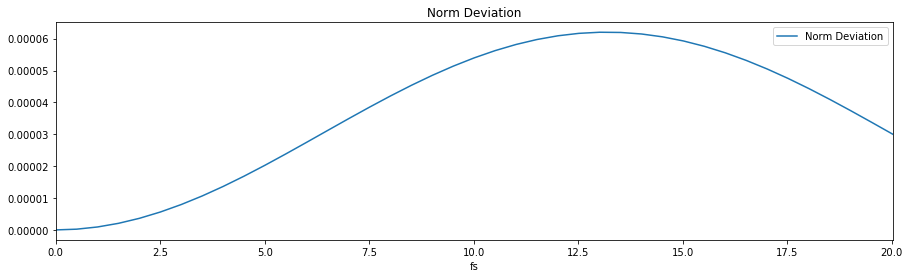

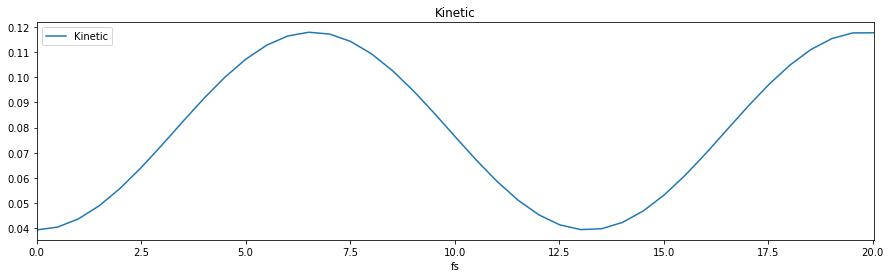

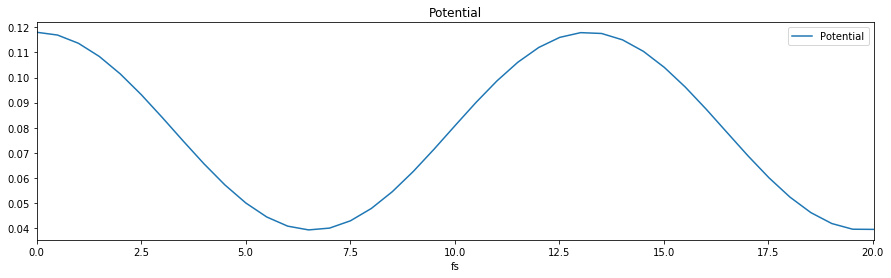

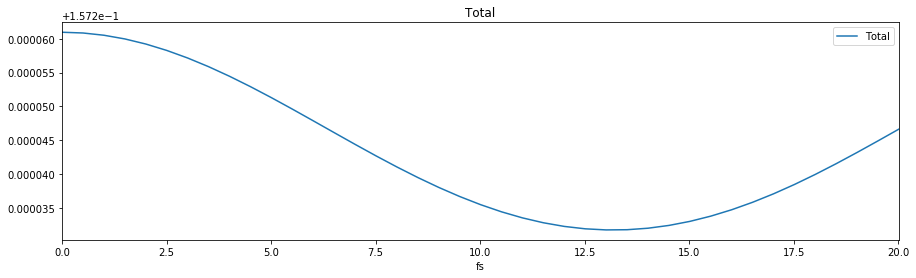

In [13]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

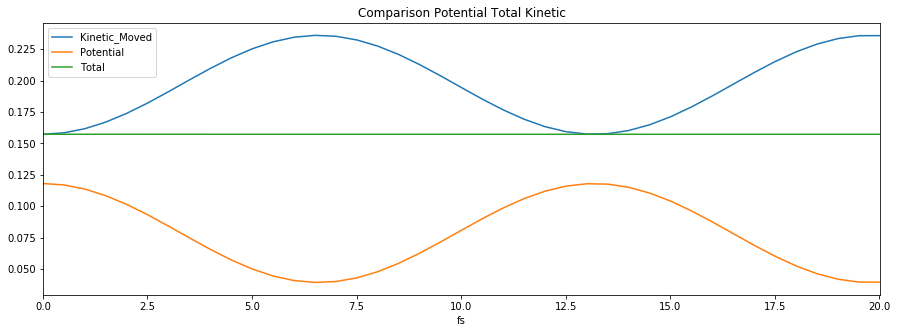

In [14]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

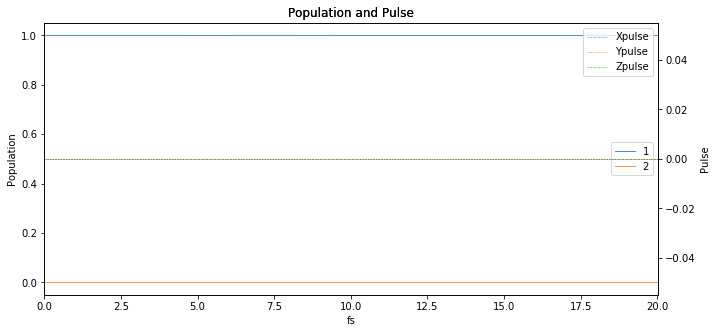

In [15]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected Value

In [16]:
def expected_1d(i):
    wf = allwf[i]
    time = alltime[i]
    print('  Time: {:5.2f} fs'.format(time))
    _,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('  Expected Values State {}:\n  Popul: {:10.3f} \n    {}: - \n'.format(i, popu**2,kind))
        else:
            wfA = abs2(wfState/popu)
            dimA = sum([ wfA[i] * dim[i] for i in range(wfA.size) ])
            print('  Expected Values State {}:\n  Popul: {:10.3f} \n    {}:   {:10.3f} \n'.format(i, popu**2, kind, dimA))

if interactive:
    interact(expected_1d, i = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    expected_1d(0)
    print('Last Step:')
    expected_1d(lastV)

interactive(children=(IntSlider(value=40, description='i', max=40), Output()), _dom_classes=('widget-interact'…

## Borders amplitudes

In [17]:
def border(i):
    left  = abs2(allwf[i,0])
    right = abs2(allwf[i,-1])
    print('Border Population:\nLeft  {}\nRight {}'.format(left,right))
    
if interactive:
    interact(border, i = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    border(0)
    print('Last Step:')
    border(lastV)

interactive(children=(IntSlider(value=40, description='i', max=40), Output()), _dom_classes=('widget-interact'…